# Rover Project Project notes as-you-go

## 1. Run through all the code

Seems like a basic procedure for rover perception. Once we have figered out how to extract:

1. Rover Position from a Map
2. Obstactle Position from a Map
3. Treasure Position from a Map

This problem of localizing will be mostly solved.Then we'll need to plan of cource for a rover.

## 2, 3. Run through a simulator to record some data

- Ok, picking up stones and navigating seems not easy due to dynamics of vehicle and navigating on a map.

## 4. Add detection of yellow rocks to image processing

- Ok, had to google image filtering code for opencv. The task is filter only yellow color on map. This will be feeded into control algorithm that will have this target objective.
- Seems harder because initial solution don't compare to subsequent

## 5. Add detection of obstacles

- Ok. Blur + Threshold on grayscale image

## 6, 7. Populate the `process_image()` function with the appropriate steps/functions to go from a raw image to a worldmap.

- Ok. Mapping from raw camera iamge to projection along with coordinates seem fine.
- Building world map shall incorporate algorithm for utilizing all these images

## 8. Incorporate code into simulator

- Note: This reminds me of a simple SLAM (simultaneus localization and mapping), but localization aprt is solved by IMU.

In [1]:
%%HTML
<style> code {background-color : orange !important;} </style>

In [2]:
%matplotlib inline
#%matplotlib qt # Choose %matplotlib qt to plot to an interactive window (note it may show up behind your browser)
# Make some of the relevant imports
import cv2 # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder
import imageio
imageio.plugins.ffmpeg.download()


## Quick Look at the Data
There's some example data provided in the `test_dataset` folder.  This basic dataset is enough to get you up and running but if you want to hone your methods more carefully you should record some data of your own to sample various scenarios in the simulator.  

Next, read in and display a random image from the `test_dataset` folder

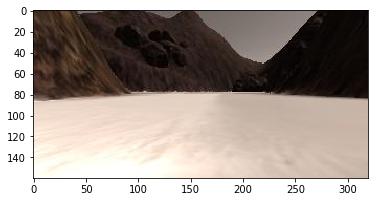

In [3]:
mode = "yellow-stones"

path = '../training_dataset/IMG/*'
img_list = glob.glob(path)
# Grab a random image and display it
yellow_tock_image_index = 132
idx = np.random.randint(0, len(img_list)-1)
if mode == "yellow-stones":
    idx = yellow_tock_image_index
image = mpimg.imread(img_list[idx])
plt.imshow(image)

## Calibration Data

Read in and display example grid and rock sample calibration images.  You'll use the grid for perspective transform and the rock image for creating a new color selection that identifies these samples of interest. 

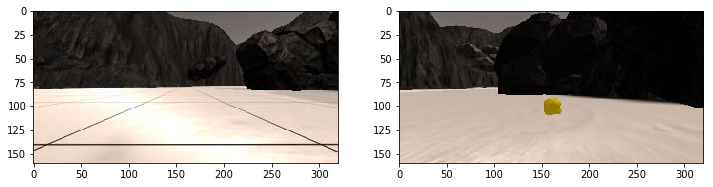

In [4]:
# In the simulator you can toggle on a grid on the ground for calibration
# You can also toggle on the rock samples with the 0 (zero) key.  
# Here's an example of the grid and one of the rocks
example_grid = '../calibration_images/example_grid1.jpg'
example_rock = '../calibration_images/example_rock1.jpg'
grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(grid_img)
plt.subplot(122)
plt.imshow(rock_img)

## Perspective Transform

Define the perspective transform function from the lesson and test it on an image.

In [5]:
dst_size = 5 
# Set a bottom offset to account for the fact that the bottom of the image 
# is not the position of the rover but a bit in front of it
# this is just a rough guess, feel free to change it!
bottom_offset = 6

# Define calibration box in source (actual) and destination (desired) coordinates
# These source and destination points are defined to warp the image
# to a grid where each 10x10 pixel square represents 1 square meter
# The destination box will be 2*dst_size on each side
source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])

def perspect_transform(img, src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))# keep same size as input image
    return warped# np.flip(warped, axis=1)

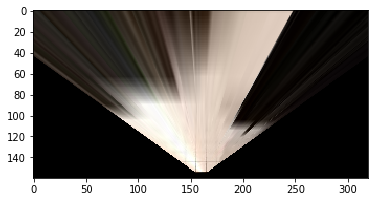

In [6]:
warped = perspect_transform(grid_img, source, destination)
plt.imshow(warped)

## Color Thresholding

In [7]:
# This function detects yellow stone object on images
# First it converts color space to HLS from RGB and then appies mask 
# on pixles whose HLS values correspond to yellow color
def color_limit_hsl(image, hsl_lower=[20,120,80], hsl_upper=[45, 200, 255]):
    # convert image to hls colour space
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS).astype(np.float)

    # hls thresholding for yellow
    lower = np.array(hsl_lower,dtype = "uint8")
    upper = np.array(hsl_upper,dtype = "uint8")
    mask = cv2.inRange(hls, lower, upper)
    
    return mask 

# Identify pixels above the threshold
# Threshold of RGB > 160 does a nice job of identifying ground pixels only
def color_threshold_rgb(img, rgb_thresh=(160, 160, 180)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select


In [8]:
def detect_ground(image):
    ground = color_threshold_rgb(image, (150, 150, 150))
    return cv2.blur(ground, (10,10))

def detect_yellow_stone(image):
    yellow_stone = cv2.blur(image,(2,2))
    return color_limit_hsl(yellow_stone, hsl_lower=[0,50,130])

def detect_obstacles(image):
    obstacles = color_threshold_rgb(image, rgb_thresh=(85, 85, 85))
    obstacles = np.invert(obstacles)

    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    grayscale = cv2.blur(grayscale,(10,10))

    grayscale[grayscale <  80] = 1
    grayscale[grayscale != 1]  = 0 
    
    return grayscale

In [9]:
# Utility function to plot original and transformed images

def plot_processing_step1(img1, img2):
    fig = plt.figure(figsize=(12,3))
    plt.subplot(121)
    plt.imshow(img1)
    plt.subplot(122)
    plt.imshow(img2)

## Navigabe ground

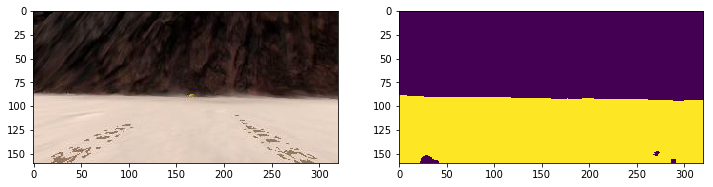

In [10]:
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])

ground = detect_ground(image)
plot_processing_step1(image, ground)

## Yellow rocks

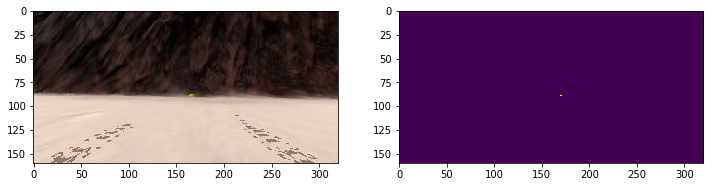

In [11]:
yellow_stone = detect_yellow_stone(image)
plot_processing_step1(image, yellow_stone)

## Obstacles

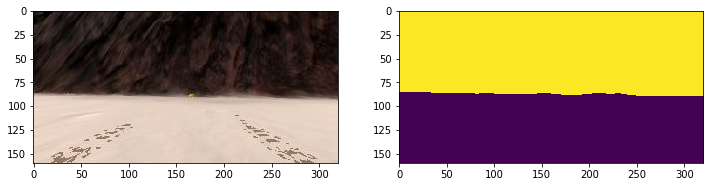

In [12]:
obstacles = detect_obstacles(image)
plot_processing_step1(image, obstacles)

## Coordinate Transformations
Define the functions used to do coordinate transforms and apply them to an image.

In [13]:
import math


def rover_coords(binary_img):
    ypos, xpos = binary_img.nonzero()
    
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.float)
    
    # image = np.zeros(binary_img.T.shape)
    # image[x_pixel.astype(np.int), y_pixel.astype(np.int)] = 1
    
    return x_pixel, y_pixel

# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

# Define a function to map rover space pixels to world space
def rotate_pix(xpix, ypix, yaw):
    # Convert yaw to radians
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))
                            
    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))
    # Return the result  
    return xpix_rotated, ypix_rotated

def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # Apply a scaling and a translation
    xpix_translated = (xpix_rot / scale) + xpos
    ypix_translated = (ypix_rot / scale) + ypos
    # Return the result  
    return xpix_translated, ypix_translated

# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world


In [14]:
def plot_processing_step2(original, processed, warped, adjusted, mask, masked):
    # Do some plotting
    fig = plt.figure(figsize=(12,9))
    
    # Orignial Image
    plt.subplot(321)
    plt.imshow(original)
    
    # Processed Image
    plt.subplot(322)
    plt.imshow(processed)
    
    # Warped Image
    plt.subplot(323)
    plt.imshow(warped)
    
    # Rotated image with arrow pointing to direction of rover
    plt.subplot(324)
    plt.imshow(adjusted)
    
    plt.subplot(325)
    plt.imshow(mask)
    
    plt.subplot(326)
    plt.imshow(masked)

In [15]:
def adjust_warped(warped):
    return np.flip(warped.T)

def vision_mask():
    center = np.array([150, 0])
    ones = np.ones((320, 160))
    for i in range(ones.shape[0]):
        for j in range(ones.shape[1]):
            point = np.array([i, j])
            distance = np.linalg.norm(point-center)
            if distance != 0:
                ones[i, j] = 1/(distance)
            if distance >= 40:
                ones[i, j] = 0
    ones[ones!=0] = 1
    return ones

In [16]:
# Grab random image
idx = 128 #np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
  
# Perofrm ground, obstacle and yellow stone detection
ground = detect_ground(image)
yellow_stone = detect_yellow_stone(image)
obstacles = detect_obstacles(image)

# Perform perspective transform
warped_ground = perspect_transform(ground, source, destination)
warped_yellow_stone = perspect_transform(yellow_stone, source, destination)
warped_obstacles = perspect_transform(obstacles, source, destination)

# Adjust 
adjusted_ground = adjust_warped(warped_ground)
adjusted_yellow_stone = adjust_warped(warped_yellow_stone)
adjusted_obstacles = adjust_warped(warped_obstacles)

# Mask visibility
mask = vision_mask()
masked_ground = adjusted_ground * mask
masked_yellow_stone = adjusted_yellow_stone * mask
masked_obstacles = adjusted_obstacles * mask

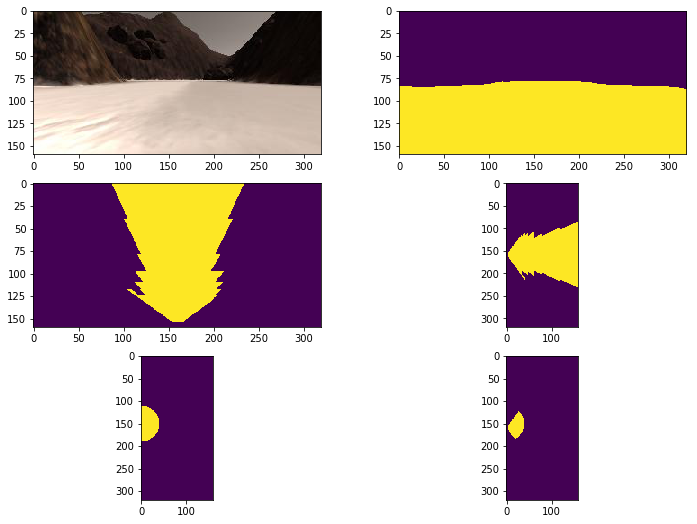

In [17]:
# Ground Phase
plot_processing_step2(image, ground, warped_ground, adjusted_ground, mask, masked_ground)

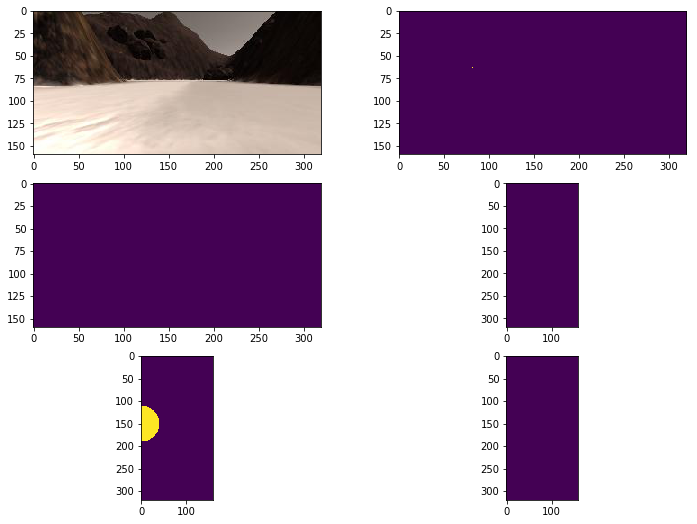

In [18]:
# Yellow Stone Phase
plot_processing_step2(image, yellow_stone, warped_yellow_stone, adjusted_yellow_stone, mask, masked_yellow_stone)

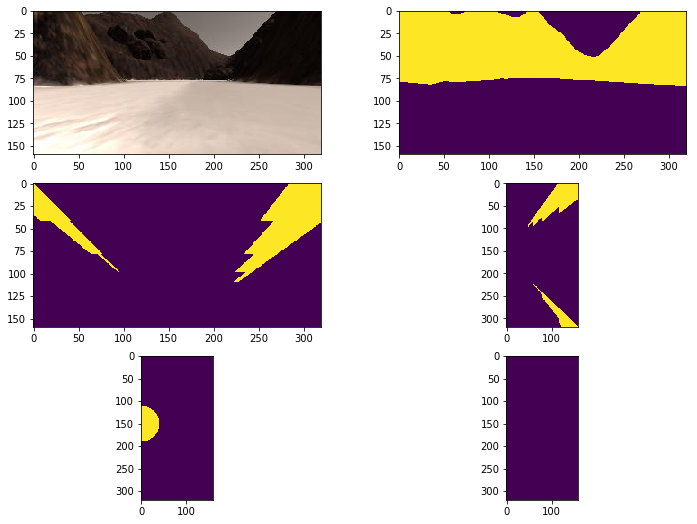

In [19]:
# Obstacle Phase
plot_processing_step2(image, obstacles, warped_obstacles, adjusted_obstacles, mask, masked_obstacles)

# World Mapper

In [52]:
def rotate_bound(image, angle):
    # grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    
    #M = cv2.getRotationMatrix2D((cX, cY),angle,1)
    #return cv2.warpAffine(img,M,(h,w))
 
    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
 
    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
 
    # adjust the rotation matrix to take into account translation
    tW = (nW / 2) - cX
    tH = (nH / 2) - cY
    M[0, 2] += tW
    M[1, 2] += tH
 
    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH))

def colorize(img: np.ndarray, maxval=128):
    newimg = np.dstack((img,img,img))
    newimg[newimg==1] = maxval
    newimg[newimg!=maxval] = 0
    #newimg = newimg * 128
    return newimg

def rotate_pix(xpix, ypix, yaw):
    # Convert yaw to radians
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))
                            
    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))
    # Return the result  
    return xpix_rotated, ypix_rotated


class WorldMapper():
    
    def __init__(self, img_list, df, ground_truth_3d):
        self.images = img_list  
        self.xpos = df["X_Position"].values
        self.ypos = df["Y_Position"].values
        self.yaw = df["Yaw"].values
        self.count = 0 # This will be a running index
        
        self.ground_map = np.zeros((200, 200, 3)).astype(np.float)
        self.obstacle_map = np.zeros((200, 200, 3)).astype(np.float)
        self.yellow_stone_map = np.zeros((200, 200, 3)).astype(np.float)
        
        self.ground_truth = ground_truth_3d # Ground truth worldmap
        self.ground_truth_frames = []
        self.movie_frames = []
        self.mask = vision_mask()
    
    def process_movie_frame_image(self, camera_view, processed, warped, x, y, yaw):
        # Put text description on camera view image
        cv2.putText(camera_view,"x: %d; y: %d; yaw: %f" % (x, y, yaw), (20, 20), 
        cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
        
        # Construct overview image
        output_image = np.zeros((camera_view.shape[0]+200, camera_view.shape[1]*3, 3))
        
        # Region 1: Camera View
        output_image[0:camera_view.shape[0], 0:camera_view.shape[1]] = camera_view
        
        # Region 2: Processed View
        output_image[0:camera_view.shape[0], camera_view.shape[1]:camera_view.shape[1]*2] = processed
        
        # Region 3: Warped View
        output_image[0:camera_view.shape[0], camera_view.shape[1]*2:camera_view.shape[1]*3] = warped
        
        # Region 4: Ground Map
        output_image[camera_view.shape[0]:, 0:200] = self.ground_truth
        output_image[camera_view.shape[0]:, 200:400] = self.ground_map
        output_image[camera_view.shape[0]:, 400:600] = self.obstacle_map
        output_image[camera_view.shape[0]:, 600:800] = self.yellow_stone_map
        
        return output_image
        
    def test_random_frame(self):
        idx = np.random.randint(0, len(self.images)-1)
        return self.process_step(idx)
    
    def process_step(self, index):
        # Load raw image
        img = mpimg.imread(self.images[index])
        # IMU data from mapping
        x, y, yaw = self.xpos[index], self.ypos[index], self.yaw[index]
        
        # Process raw frame to get maps for Ground, Yellow Stone and Obstacles
        o = detect_obstacles(img)
        g = detect_ground(img)
        ys = detect_yellow_stone(img)

        # Perform perspective transform
        wg = perspect_transform(g, source, destination)
        wys = perspect_transform(ys, source, destination)
        wo = perspect_transform(o, source, destination)

        # Perform rotation
        ag = adjust_warped(wg) * self.mask
        ays = adjust_warped(wys) * self.mask
        ao = adjust_warped(wo) * self.mask
        
        # Technical Vision       
        tv = colorize(g, 100) + colorize(ys, 255) + colorize(o, 50)
        
        # Warped View
        wv = colorize(ag, 100) + colorize(ays, 255) + colorize(ao, 50)
        wv = cv2.resize(wv, (img.shape[1], img.shape[0]))
        
        # Ground Map
        wmg = self.convert_from_rover_frame_to_world_frame(ag, x, y, yaw)
        wmys = self.convert_from_rover_frame_to_world_frame(ays, x, y, yaw)
        wmo = self.convert_from_rover_frame_to_world_frame(ao, x, y, yaw)
        
        self.ground_map += wmg 
        self.obstacle_map += wmo
        self.yellow_stone_map += wmys
        
        return self.process_movie_frame_image(img, tv, wv, x, y, yaw)
    
    def process_dataset(self):
        frames = []
        for i in range(len(self.ypos)):
            frames.append(self.process_step(i))
        return frames
    
    def convert_from_rover_frame_to_world_frame(self, img, x, y, yaw, world_size=200):
        result = np.zeros((200, 200, 3))
        scaled = cv2.resize(img, None, fx=0.2, fy=0.2)
       
        for i in range(scaled.shape[0]):
            for j in range(scaled.shape[1]):
                (_i, _j) = rotate_pix(j, i-32, yaw)
                _x = int(_i + x)
                _y = int(_j + y)
                
                if 0 <= _x < result.shape[0] and 0 <= _y < result.shape[1]:
                    result[_x, _y, 0] = scaled[i, j] * 20
        
        return result


In [53]:
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip
from IPython.display import HTML
import pandas as pd

df = pd.read_csv('../test_dataset/robot_log.csv', delimiter=';', decimal='.')
csv_img_list = df["Path"].tolist() # Create list of image pathnames
# Read in ground truth map and create a 3-channel image with it
ground_truth = mpimg.imread('../calibration_images/map_bw.png')
ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float)

world_mapper = WorldMapper(csv_img_list, df, ground_truth_3d)

#frame = world_mapper.test_random_frame()
#plt.imshow(frame)

frames = world_mapper.process_dataset()

clip = ImageSequenceClip(frames, fps=60) 
output = '../output/world_map.mp4'
clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ../output/world_map.mp4
[MoviePy] Writing video ../output/world_map.mp4


100%|██████████| 283/283 [00:00<00:00, 446.98it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output/world_map.mp4 



In [22]:
HTML("""
<video width="960" height="720" controls>
  <source src="{0}">
</video>
""".format(output))